<font color='#E27271'>

# *Unveiling Complex Interconnections Among Companies through Learned Embeddings*</font>

-----------------------
<font color='#E27271'>

Ethan Moody, Eugene Oon, and Sam Shinde</font>

<font color='#E27271'>

August 2023</font>

-----------------------
<font color='#00AED3'>

# **Alternative Classification Method** </font>
-----------------------

We explored various alternative classification methods as follows:

* Louvain Modularity: This algorithm detects communities based on the cosine similarity of the stock embeddings.

* Minimum Spanning Tree: We employed this algorithm to visualize the intricate interconnectedness of the stocks, allowing for the possibility of pruning to identify potential clusters.

* Hierarchical Clustering: The algorithm was utilized to detect clusters based on a specific threshold.

* KMeans Clustering: We investigated two different approaches with KMeans clustering. Firstly, we clustered all stocks into a single cluster. Secondly, we performed clustering of stocks into multiple clusters based on their distances within a specific percentile of each cluster.

By exploring these alternative classification methods, we aimed to gain insights into different ways of grouping and organizing stocks based on their embeddings or distance metrics.

## [1] Installs, Imports and Setup Steps

### [1.1] Complete Initial Installs and Import Packages

In [ ]:
import numpy as np
import pandas as pd
import json

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
pd.options.display.float_format = '{:,}'.format

import warnings
warnings.filterwarnings('ignore')

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### [1.2] Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## [2] Exploration of Different Methods to Unveil and Cluster Stock Embeddings

### [2.1] Load and check the stock embeddings and labels

In [ ]:
# Path for S&P500 embeddings dataset
data_file_path = '/content/drive/My Drive/Colab Notebooks/project/sp500_2022bus_embed_final.csv'

# Read the CSV file into a new DataFrame
df_data = pd.read_csv(data_file_path, index_col=0)

In [ ]:
# Path for S&P500 dataset
label_file_path = '/content/drive/My Drive/Colab Notebooks/project/sp500_2022bus_final.csv'

# Read the CSV file back into a new DataFrame
df_label = pd.read_csv(label_file_path)

In [ ]:
# Create a dictionary to store the mapping of each unique 'sector' value to its corresponding numerical label
label_dict = {'Communication Services': 0, 'Consumer Discretionary': 1,'Consumer Staples': 1,
              'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5,
              'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Utilities': 9}

# Map the 'sector' values to their corresponding numerical labels
df_label["label"] = df_label["sector"].replace(label_dict)

# Filter for "name", "ticker", "sector" and "label" columns
df_label = df_label[["name", "ticker", "sector", "label"]]

# Create a dictionary where "name" is key and inner dictionaries with "ticker", "sector" & "label" as keys
name_sector_label_dict =  df_label.set_index("name").to_dict(orient="index")

In [ ]:
# Function to normalize column-wise of DataFrame - similar to sklearn StandardScaler()
def z_score_normalization(df):
    # Calculate the mean and standard deviation of each column
    mean = df.mean()
    std = df.std()
    # Perform Z-score normalization by column
    df_normalized = (df - mean) / std
    return df_normalized

# Create new DataFrame with normalized embeddings
df_data_norm = z_score_normalization(df_data)

### [2.2] Compute cosine similarity and distance
Reference: https://en.wikipedia.org/wiki/Cosine_similarity

In [ ]:
# Calculate the cosine similarity matrix for "df_data" and "df_data_norm"
cos_sim_matrix = cosine_similarity(df_data)
cos_sim_norm_matrix = cosine_similarity(df_data_norm)

# Create DataFrames from the cosine similarity matrices
df_cos_sim = pd.DataFrame(cos_sim_matrix, index=df_data.T.columns, columns=df_data.T.columns)
df_cos_sim_norm = pd.DataFrame(cos_sim_norm_matrix, index=df_data_norm.T.columns, columns=df_data_norm.T.columns)

# Calculate the cosine distance matrix by subtracting the cosine similarity matrix from 1
cos_dist_matrix = 1 - df_cos_sim
cos_dist_norm_matrix = 1 - df_cos_sim_norm

### [2.3] Create functions to explore outputs

In [ ]:
# List comprehension to find different companies

chosen_df = df_cos_sim # change as appropriate
y = "Net" # change as appropriate

[x for x in sorted(chosen_df.columns.unique().tolist()) if x.startswith(y)]

['NetApp Inc.', 'Netflix Inc']

In [ ]:
# Sort companies that are most similar to selected company

select_df = df_cos_sim # change as appropriate
select_co = "Tesla Inc" # change as appropriate

select_df.loc[select_co].sort_values(ascending=False).head(10)

Tesla Inc                     1.000000
Enphase Energy Inc            0.855759
Cummins Inc.                  0.853369
General Motors Co             0.851699
Generac Holdings Inc          0.847051
Aptiv PLC                     0.842956
Solaredge Technologies Inc    0.830171
LKQ Corp                      0.829915
First Solar Inc               0.825653
Genuine Parts Co              0.823376
Name: Tesla Inc, dtype: float64

### [2.4] Deploy Louvain Modularity to detect communities

In [ ]:
def detect_communities_with_louvain(stock_embeddings, name_sector_label_dict, cos_sim_matrix):
  """
  Detect communities in a graph of stock embeddings using Louvain modularity optimization.

  Parameters:
  stock_embeddings (pandas DataFrame): Stock embeddings of companies (num_stocks, embedding_dimension)
  cos_sim_matrix (numpy array): Matrix of cosine similarity values between stock
  name_sector_label_dict (dictionary): Stock name (key) with sector name (value) and numerical label (value)

  Returns:
  None (Prints detected communities)
  """

  # Labels for each company
  company_labels = list(stock_embeddings.index)

  # Create an undirected graph using cosine similarity data
  G = nx.Graph()
  num_companies = cos_sim_matrix.shape[0]

  # Add nodes to the graph (companies) with labels
  G.add_nodes_from(range(num_companies))
  node_labels = dict(zip(range(num_companies), company_labels))
  nx.set_node_attributes(G, node_labels, 'label')

  # Add edges to the graph with cosine similarity as edge weights
  for i in range(num_companies):
    for j in range(i + 1, num_companies):
      similarity = cos_sim_matrix[i, j]
      G.add_edge(i, j, weight=similarity)

  # Apply Louvain modularity optimization
  communities = nx.community.louvain_communities(G, weight='weight')

  # Store the detected communities and their member companies in a dictionary
  community_dict = {}
  for community_id, companies in enumerate(communities):
    community_labels = [node_labels[node] for node in companies]
    community_dict[community_id + 1] = community_labels

  # Print the detected communities
  for community_id, companies in community_dict.items():
    print(f"Community {community_id}: {', '.join(companies)}")
    print("-"*75)
    # Print the top 10 companies for each community based on their labels
    print(f"First 10 companies in Community {community_id}:")
    for idx, company in enumerate(companies[:10], start=1):
      sector_label = name_sector_label_dict[company]["sector"]
      print(f" {idx}. {company}: {sector_label}")
    print("="*75)

In [ ]:
detect_communities_with_louvain(df_data, name_sector_label_dict, cos_sim_matrix)

Community 1: JPMorgan Chase & Co, Bank of America Corp, Wells Fargo & Co, Citigroup Inc, US Bancorp, PNC Financial Services Group Inc, Truist Financial Corp, M&t Bank Corp, Fifth Third Bancorp, Regions Financial Corp, Huntington Bancshares Incorporated, Citizens Financial Group Inc, KeyCorp, Molina Healthcare Inc, Zions Bancorporation NA, Comerica Incorporated, Universal Health Services, Inc., 3M Co, Marsh & McLennan Companies Inc, Progressive Corp, Chubb Ltd, Arthur J. Gallagher & Co., Metlife Inc, AFLAC Incorporated, American International Group Inc, Travelers Companies Inc, Allstate Corp, Arch Capital Group Ltd., Willis Towers Watson PLC, Hartford Financial Services Group Inc, L3Harris Technologies Inc, Principal Financial Group Inc, Brown & Brown, Inc., Cincinnati Financial Corporation, W R Berkley Corp, Globe Life Inc, Assurant, Inc., Lincoln National Corp, Equifax Inc, Broadridge Financial Solutions, Inc., Comcast Corporation, Walt Disney Co, Warner Bros Discovery Inc, Paramount 

### [2.5] Explore complex relationships via Minimum Spanning Tree

In [ ]:
# List of companies to highlight in the minimum spanning tree
companies_to_highlight = ["Amazon.com, Inc.", "Apple Inc", "Microsoft Corp",
                          "ALPHABET INC CL C", "Meta Platforms Inc", "Netflix Inc"]

# Create a graph using the cosine distance matrix values
graph = nx.from_numpy_array(cos_dist_matrix.values)

# Compute the minimum spanning tree of the graph
mst = nx.minimum_spanning_tree(graph)

# Create a matplotlib figure
plt.figure(figsize=(20, 20))

# Generate positions for the nodes using a spring layout algorithm
pos = nx.spring_layout(mst, seed=42)

# Create custom labels for nodes, mapping the node index to the corresponding label from the DataFrame
custom_labels = {i: df_cos_sim.columns[i]
                 for i in range(cos_dist_matrix.shape[0])}

# Find the node indices for the companies to highlight
highlight_node_indices = [i for i, label in custom_labels.items() if label in companies_to_highlight]

# Set the node color for the highlighted companies to a different color (e.g., red), others to default color (skyblue)
node_colors = ["skyblue" if i not in highlight_node_indices else "red" for i in range(len(custom_labels))]

nx.draw(mst, pos, labels=custom_labels, with_labels=True,
        node_color=node_colors, font_size=10, node_size=100)

nx.draw_networkx_edge_labels(
    mst, pos, edge_labels={(u, v): f"{d['weight']:.2f}"
                           for u, v, d in mst.edges(data=True)}, font_size=5)

plt.title("Minimum Spanning Tree for the S&P 500", fontsize=24)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### [2.6] Deploy Hierarchical Clustering to detect clusters

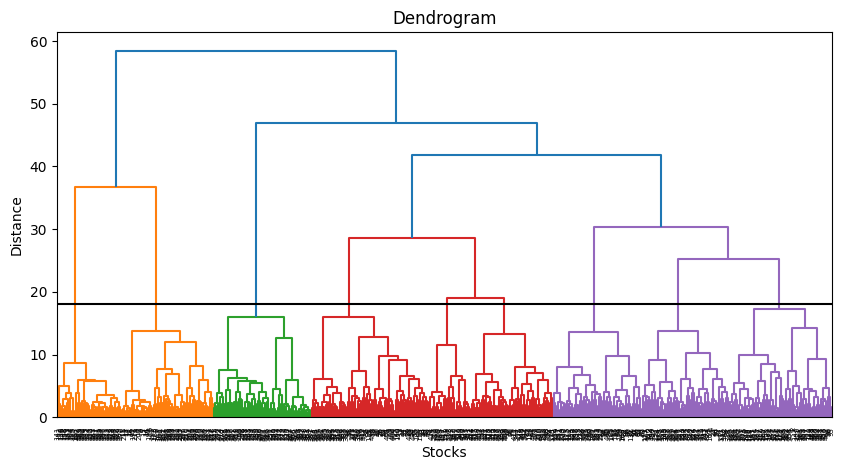

In [ ]:
# Use hierarchical clustering to form clusters
Z = linkage(cos_sim_norm_matrix, method='ward')

# Plot the dendrogram to visualize clusters
plt.figure(figsize=(10, 5))
dendrogram(Z)

# Determine the threshold based on the dendrogram
threshold = 18
plt.axhline(y=threshold, c='k')

plt.title("Dendrogram")
plt.xlabel("Stocks")
plt.ylabel("Distance")
plt.show()

In [ ]:
# Form clusters based on the threshold
cluster_labels = fcluster(Z, t=threshold, criterion='distance')

# Create a dictionary to store stocks for each cluster
clusters = {}
for stock_name, cluster_label in zip(df_data_norm.index, cluster_labels):
  if cluster_label not in clusters:
    clusters[cluster_label] = []
  clusters[cluster_label].append(stock_name)

# Print the first 10 stocks in each cluster
for c_label, c_stocks in clusters.items():
  print("Cluster Label:", c_label)
  print("-"*75)
  print(f"First 10 companies in Cluster {c_label}:")
  for idx, stockx in enumerate(c_stocks[:10], start=1):
    sector_label = name_sector_label_dict[stockx]["sector"]
    print(f" {idx}. {stockx}: {sector_label}")
  print("="*75)

Cluster Label: 4
---------------------------------------------------------------------------
First 10 companies in Cluster 4:
 1. Tesla Inc: Consumer Discretionary
 2. Aptiv PLC: Consumer Discretionary
 3. Raytheon Technologies Corp: Industrials
 4. Honeywell International Inc: Industrials
 5. Boeing Co: Industrials
 6. General Electric Co: Industrials
 7. Lockheed Martin Corp: Industrials
 8. Illinois Tool Works Inc.: Industrials
 9. Northrop Grumman Corp: Industrials
 10. General Dynamics Corp: Industrials
Cluster Label: 9
---------------------------------------------------------------------------
First 10 companies in Cluster 9:
 1. Ford Motor Co: Consumer Discretionary
 2. General Motors Co: Consumer Discretionary
 3. Copart, Inc.: Industrials
 4. CarMax, Inc: Consumer Discretionary
 5. Advance Auto Parts, Inc.: Consumer Discretionary
 6. DR Horton Inc: Consumer Discretionary
 7. Lennar Corp: Consumer Discretionary
 8. NVR Inc: Consumer Discretionary
 9. PulteGroup, Inc.: Consumer 

### [2.7] Deploy KMeans clustering to detect clusters

#### Explore optimal number of clusters using the Elbow Method

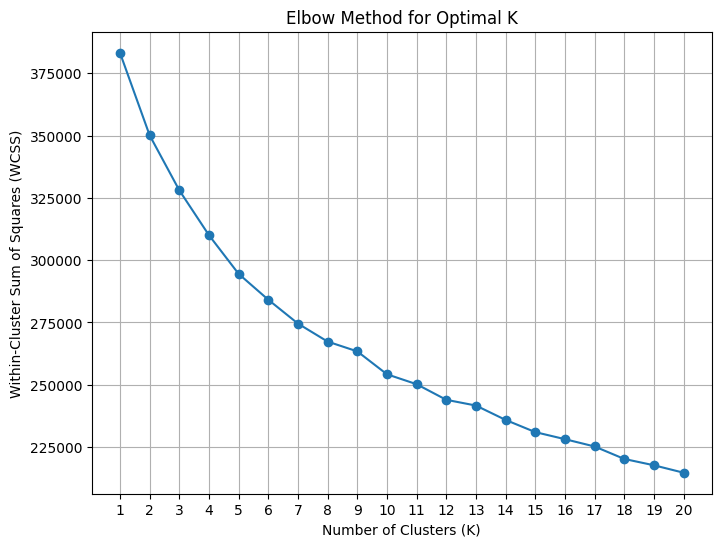

In [ ]:
# Number of clusters to explore
exp_cluster = 20

# Dictionary to store the WCSS values for each K
wcss_values = {}

# Try different values of K (clusters) using K-means
for num_clusters in range(1, exp_cluster+1):
  kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state = 42)
  kmeans.fit(df_data_norm)
  wcss_values[num_clusters] = kmeans.inertia_

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(list(wcss_values.keys()), list(wcss_values.values()), marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.xticks(np.arange(1, exp_cluster+1, 1))
plt.grid(True)
plt.show()

#### Approach 1: Each stock grouped into a single cluster

In [ ]:
def detect_communities_with_kmeans(stock_embeddings, stock_labels, name_sector_label_dict, num_clusters):
    """
    Detect communities in a graph of stock embeddings using K-means clustering

    Parameters:
    stock_embeddings (pandas DataFrame): Stock embeddings of companies (num_stocks, embedding_dimension)
    stock_labels (list): List of stock labels corresponding to the rows of stock_embeddings
    name_sector_label_dict (dictionary): Stock name (key) with sector name (value), ticker (value) and numerical label (value)
    num_clusters (int): Number of clusters (desired number of communities)

    Returns:
    communities_dict (dictionary): Dictionary of stocks in their respective communities assigned
    kmeans (KMeans): The fitted KMeans object
    It also prints detected communities
    """
    # Apply K-means clustering on the stock embeddings
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state = 42)
    cluster_labels = kmeans.fit_predict(stock_embeddings)

    # Organize stocks into communities based on cluster assignments
    communities = [[] for _ in range(num_clusters)]
    for stock_idx, cluster_label in enumerate(cluster_labels):
        communities[cluster_label].append(stock_idx)

    # Initialize dictionary to store communities and stock constituents
    communities_dict = {}

    for community_id, stocks_in_community in enumerate(communities):
        # Get the indices of stocks in the current community
        community_stock_indices = stocks_in_community
        # Calculate the centroid of the current community
        community_centroid = np.mean(stock_embeddings.iloc[community_stock_indices], axis=0)
        # Calculate the distances of each company in the community to the centroid
        distances_to_centroid = np.linalg.norm(stock_embeddings.iloc[community_stock_indices] - community_centroid, axis=1)
        # Combine companies, sector labels, tickers, and their distances in a list of tuples
        companies_with_distances = [
            (stock_labels[idx], name_sector_label_dict[stock_labels[idx]]["sector"],
             name_sector_label_dict[stock_labels[idx]]["ticker"], distance)
            for idx, distance in zip(community_stock_indices, distances_to_centroid)
        ]

        # Sort the companies in the community based on their distances to the centroid (from smallest to biggest)
        companies_with_distances.sort(key=lambda x: x[3])

        # Extract the tickers of companies in the current community
        tickers_in_community = [company_data[2] for company_data in companies_with_distances]
        # Store the tickers in the communities_dict with community_id as the key
        communities_dict[community_id + 1] = tickers_in_community

        # Print the detected communities with companies, tickers, and their sector labels and distances to the respective centroid
        print(f"Community {community_id + 1}:")
        for idx, (company, sector_label, ticker, distance) in enumerate(companies_with_distances, start=1):
            print(f"   {idx}. {company} ({ticker}) -- Sector: {sector_label}, Distance to Centroid: {distance:.4f}")

    return communities_dict, kmeans


In [ ]:
communities_dict, kmeans = detect_communities_with_kmeans(df_data_norm, pd.Series(list(df_data_norm.index)), name_sector_label_dict, 15)

Community 1:
   1. Comcast Corporation (CMCSA) -- Sector: Communication Services, Distance to Centroid: 13.6803
   2. Charter Communications Inc (CHTR) -- Sector: Communication Services, Distance to Centroid: 17.5589
   3. Warner Bros Discovery Inc (WBD) -- Sector: Communication Services, Distance to Centroid: 19.5849
   4. Paramount Global (PARA) -- Sector: Communication Services, Distance to Centroid: 20.4022
   5. AT&T Inc. (T) -- Sector: Communication Services, Distance to Centroid: 20.7714
   6. T-Mobile Us Inc (TMUS) -- Sector: Communication Services, Distance to Centroid: 21.4039
   7. Verizon Communications Inc. (VZ) -- Sector: Communication Services, Distance to Centroid: 22.7917
   8. NEWS CORP (NWS) -- Sector: Communication Services, Distance to Centroid: 24.0867
   9. FOX CORP (FOX) -- Sector: Communication Services, Distance to Centroid: 24.1319
   10. Walt Disney Co (DIS) -- Sector: Communication Services, Distance to Centroid: 27.2764
Community 2:
   1. Mid-America Apart

In [ ]:
# Define the path to extract "communities_dict" to JSON
communities_dict_file_path = '/content/drive/My Drive/Colab Notebooks/project/communities_dict.json'

# Save the dictionary to a JSON file
with open(communities_dict_file_path, 'w') as f:
  json.dump(communities_dict, f)

#### Approach 2: Each stock grouped into single or multiple clusters

In [ ]:
# Create function to get distances to centroid for specific stock

def get_distances_to_centroids(stock_name, stock_embeddings, stock_labels, kmeans):
    """
    Get distances of a stock to each of the centroids.

    Parameters:
    stock_name (str): Name of the stock for which distances are calculated
    stock_embeddings (pandas DataFrame): Stock embeddings of companies (num_stocks, embedding_dimension)
    stock_labels (list): List of stock labels corresponding to the rows of stock_embeddings
    kmeans (KMeans): Fitted KMeans object

    Returns:
    list: A list of distances of the stock to each of the centroids
    """
    # Find the index of the stock in the stock_labels list
    stock_idx = stock_labels.index(stock_name)
    # Get the stock's embedding
    stock_embedding = stock_embeddings.iloc[stock_idx]
    # Calculate the distances of the stock to each of the centroids
    distances_to_centroids = [np.linalg.norm(stock_embedding - centroid) for centroid in kmeans.cluster_centers_]

    return distances_to_centroids

In [ ]:
# Call the function to get distances of a stock to each centroid
stock_name = "Amazon.com, Inc."

distances_to_centroids = get_distances_to_centroids(stock_name, df_data_norm, list(df_data_norm.index), kmeans)

# Print the distances to each centroid
for centroid_idx, distance in enumerate(distances_to_centroids):
    print(f"Centroid {centroid_idx + 1}: Distance: {distance:.4f}")

Centroid 1: Distance: 33.9143
Centroid 2: Distance: 31.9305
Centroid 3: Distance: 40.1221
Centroid 4: Distance: 36.1660
Centroid 5: Distance: 30.2191
Centroid 6: Distance: 26.2565
Centroid 7: Distance: 41.3137
Centroid 8: Distance: 35.4535
Centroid 9: Distance: 31.9621
Centroid 10: Distance: 22.6142
Centroid 11: Distance: 41.9539
Centroid 12: Distance: 38.8451
Centroid 13: Distance: 32.3286
Centroid 14: Distance: 29.1735
Centroid 15: Distance: 24.4692


In [ ]:
# Calculate distances to each cluster for all stocks, preserving only those
# that meet threhold and derive normalized weights against each cluster

# Get the stock names
stock_names = df_label["name"]

# Create an empty dictionary to store distances for each stock
stock_distances = {}

# Loop through all stock names and store their distances to each centroid
for stock_name in stock_names:
    distances_to_centroids = get_distances_to_centroids(stock_name, df_data_norm, list(df_data_norm.index), kmeans)
    stock_ticker = name_sector_label_dict[stock_name]["ticker"]
    stock_distances[stock_ticker] = distances_to_centroids

# Convert the dictionary to a DataFrame
df_distances = pd.DataFrame(stock_distances)

# Calculate the threshold at 25th percentile for each centroid
thresholds = df_distances.apply(lambda x: np.percentile(x, 25), axis=0)

# Create a new DataFrame with the same index and columns as df_distances
df_clusters = df_distances.copy()

# Compare each value in df_distances against the corresponding threshold
# Set values greater than the threshold to 0
df_clusters = pd.DataFrame(np.where(df_distances > thresholds, 0, df_distances), index=df_distances.index, columns=df_distances.columns)

# Normalize each column to weights that sum to 1
df_clusters_norm = df_clusters.div(df_clusters.sum(axis=0), axis=1)
df_clusters_norm = df_clusters_norm.T
df_clusters_norm.columns = range(1, 16)

# Print the resulting DataFrame
display(df_clusters_norm)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
TSLA,0.0,0.000000,0.000000,0.000000,0.223508,0.254287,0.268789,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.253416,0.000000
F,0.0,0.000000,0.000000,0.157887,0.000000,0.286785,0.000000,0.275518,0.0,0.000000,0.0,0.000000,0.000000,0.279810,0.000000
GM,0.0,0.000000,0.000000,0.236924,0.000000,0.259568,0.000000,0.255652,0.0,0.000000,0.0,0.000000,0.000000,0.247857,0.000000
APTV,0.0,0.000000,0.000000,0.000000,0.218561,0.239533,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.263719,0.278187
BWA,0.0,0.000000,0.000000,0.000000,0.260203,0.210537,0.000000,0.000000,0.0,0.279831,0.0,0.000000,0.000000,0.249429,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNW,0.0,0.286058,0.000000,0.000000,0.000000,0.000000,0.191296,0.239611,0.0,0.000000,0.0,0.000000,0.000000,0.283034,0.000000
NRG,0.0,0.000000,0.000000,0.000000,0.000000,0.303124,0.161761,0.243460,0.0,0.000000,0.0,0.000000,0.000000,0.291655,0.000000
RE,0.0,0.276722,0.260512,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.274936,0.187830,0.000000,0.000000
CBOE,0.0,0.000000,0.244996,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.219809,0.269187,0.266007


In [ ]:
# Define the path where the extracted data will be saved as a CSV file
clusters_norm_csv_path = '/content/drive/My Drive/Colab Notebooks/project/kmean2_clusters_norm.csv'

# Save the DataFrame to the specified CSV file
df_clusters_norm.to_csv(clusters_norm_csv_path,index=True)

#### Plot KMeans Clustering with t-SNE

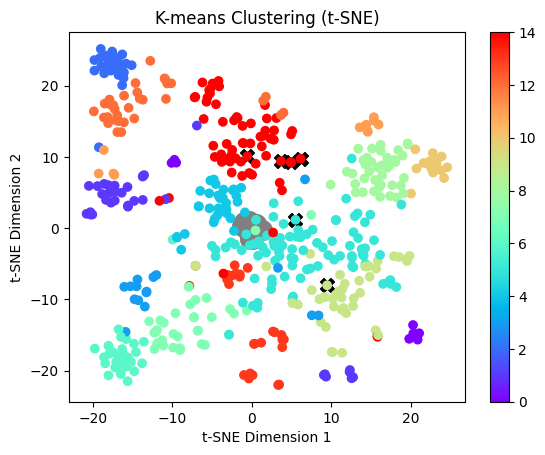

In [ ]:
centroids = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# Reduce dimensionality with t-SNE to visualize the clusters
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(df_data_norm)

specific_company_names = ["Amazon.com, Inc.", "Apple Inc", "Microsoft Corp",
                          "ALPHABET INC CL C", "Meta Platforms Inc", "Netflix Inc"]

specific_company_indices = [df_data_norm.index.get_loc(name) for name in specific_company_names]
specific_company_positions = embeddings_2d[specific_company_indices]
plt.scatter(specific_company_positions[:, 0], specific_company_positions[:, 1],
            color='black', marker='X', s=100, label='Specific Companies')

plt.scatter(centroids[:, 0], centroids[:, 1], c='grey', marker='o', s=200, label='Centroids')

# Plot the scatter plot with cluster assignments
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='rainbow')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('K-means Clustering (t-SNE)')
plt.colorbar()
plt.show()

## [2.8] Multi GICS Classification

### Load Predictions (RoBERTa)

In [ ]:
# Path
pred_file_path = '/content/drive/My Drive/project/data/embeddings/rbert_predictions.csv'

# Load Predictions
df = pd.read_csv(pred_file_path)

df_pred = df
df_pred.reset_index(drop=True, inplace=True)
df_pred['tickername'] = df_pred['ticker'] + '-' + df_pred['name']

# Drop the columns that are not needed
df_pred.drop(['ticker','name'], axis=1, inplace=True)
df_pred.set_index('tickername', inplace=True)
df_pred.head(2)

,0,1,2,3,4,5,6,7,8,9
tickername,,,,,,,,,,
TSLA-Tesla Inc,0.0039149444,0.93539447,0.0014573622,0.0014312257,0.0034654215,0.043880068,0.004076197,0.0022442003,0.0020936013,0.0020425164
F-Ford Motor Co,0.0012056833,0.9857568,0.0006744366,0.0006936488,0.0016770887,0.0075121257,0.0006353647,0.00044248757,0.0008891542,0.0005132111


### Extract Relationship

In [ ]:
# Color Palette
palette = sns.color_palette("husl", n_colors=10)

# Label Dictionary
label_dict = {'0':'Communication Services',
              '1':'Consumer Discretionary and Staples',
              '2':'Energy',
              '3':'Financials',
              '4':'Health Care',
              '5':'Industrials',
              '6':'Information Technology',
              '7':'Materials',
              '8':'Real Estate',
              '9':'Utilities'}

relationship = []
cnt=1
ttlcnt=df_pred.shape[0]

# Predictions < 0.1 are excluded, as they are deemed to lack sufficient confidence
for index, row in df_pred.iterrows():
  row100 = row * 10
  rownorm = row100.astype(int)/sum(row100.astype(int))
  for idx, value in rownorm.items():
    if value != 0:
      result = {
          'tickername': index,
          'label':idx,
          'labelname':label_dict[idx],
          'weight':round(value,2),
          'color':palette[int(idx)]
      }
      relationship.append(result)
  print('\b'*100, end = '')
  print(f'{cnt}/{ttlcnt}', end='')
  cnt+=1

1/5002/5003/5004/5005/5006/5007/5008/5009/500

In [ ]:
df_relationship = pd.DataFrame.from_dict(relationship)
df_relationship.head(5)

,tickername,label,labelname,weight,color
0,TSLA-Tesla Inc,1,Consumer Discretionary and Staples,1.0,"(0.8616090647292522, 0.536495730113334, 0.1954..."
1,F-Ford Motor Co,1,Consumer Discretionary and Staples,1.0,"(0.8616090647292522, 0.536495730113334, 0.1954..."
2,GM-General Motors Co,1,Consumer Discretionary and Staples,1.0,"(0.8616090647292522, 0.536495730113334, 0.1954..."
3,APTV-Aptiv PLC,1,Consumer Discretionary and Staples,1.0,"(0.8616090647292522, 0.536495730113334, 0.1954..."
4,BWA-BorgWarner Inc.,1,Consumer Discretionary and Staples,1.0,"(0.8616090647292522, 0.536495730113334, 0.1954..."


### Graph Analysis and Visualization

In [ ]:
# Graph Analysis and Visualization
G = nx.from_pandas_edgelist(df_relationship,
                            source='tickername',
                            target='labelname',
                            edge_attr='weight',
                            create_using=nx.DiGraph())

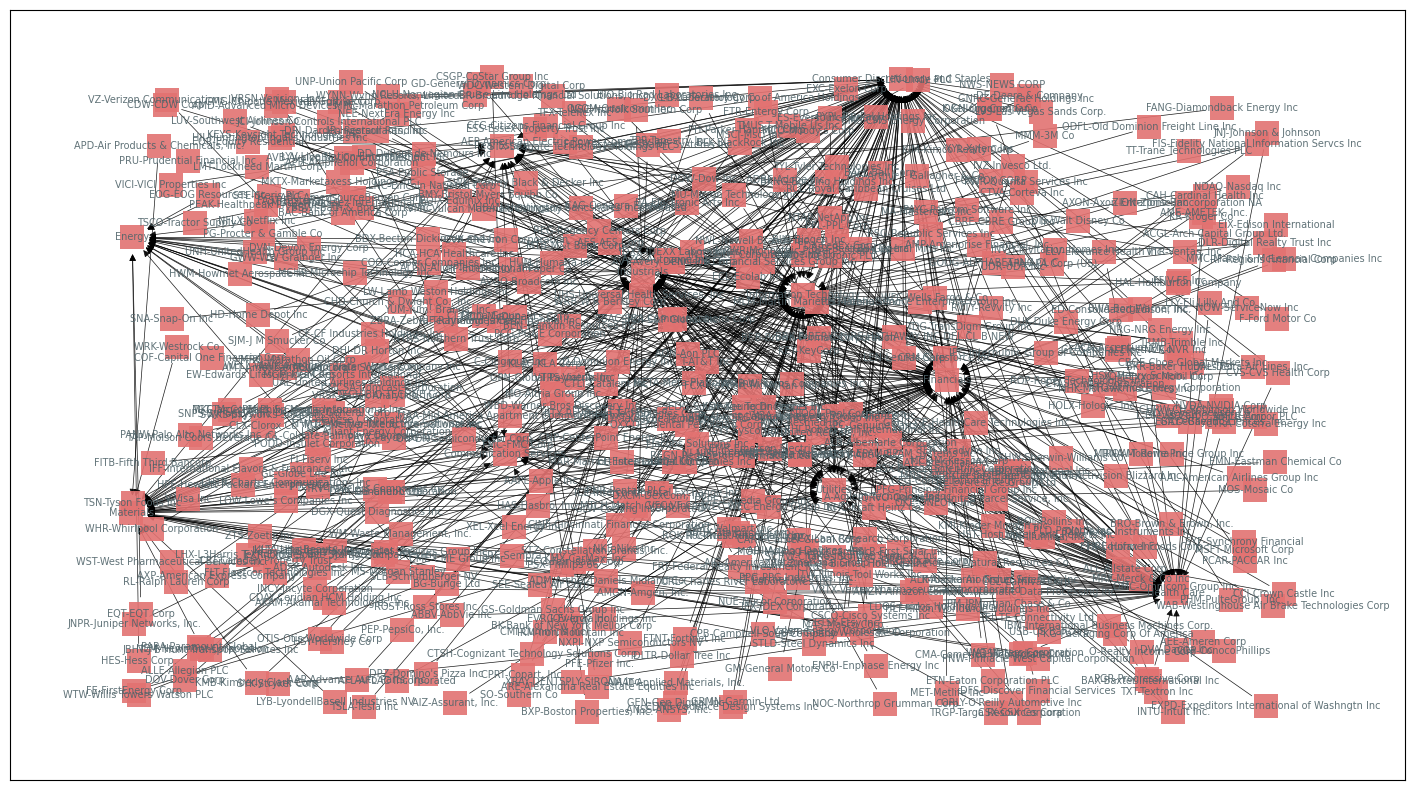

In [ ]:
plt.figure(figsize=(18,10))

# pos = nx.kamada_kawai_layout(G)
# pos = nx.planar_layout(G)
pos = nx.random_layout(G)
# pos = nx.shell_layout(G)
nx.draw_networkx(G, with_labels=True,
                 node_color='#E27271',
                 edge_cmap=plt.cm.Blues,
                 font_color="#50646A",
                 pos=pos,
                 node_shape="s",
                 alpha=0.9,
                 font_size=7,
                 linewidths=0,
                 width=0.5)
plt.show()

In [ ]:
# Extract Centrality, Betweenness, Closeness and Degree Centrality
degree_dict = nx.degree_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)
closeness_dict = nx.closeness_centrality(G)
node_degree = dict(G.degree)

In [ ]:
# Communities
cluster = ['Communication Services',
           'Consumer Discretionary and Staples',
           'Energy',
           'Financials',
           'Health Care',
           'Industrials',
           'Information Technology',
           'Materials',
           'Real Estate',
           'Utilities']
communities = {k:v for k,v in node_degree.items() if k in cluster}
communities

{'Consumer Discretionary and Staples': 109,
 'Financials': 77,
 'Industrials': 98,
 'Information Technology': 86,
 'Health Care': 67,
 'Materials': 41,
 'Communication Services': 26,
 'Real Estate': 28,
 'Energy': 24,
 'Utilities': 30}

In [ ]:
from pyvis.network import Network

net = Network(notebook=True, height='1200px', width='100%',bgcolor="white", font_color="grey",cdn_resources='remote', select_menu=True)
#net.node_font_size = 50
nx.set_node_attributes(G, node_degree, 'size')
#nx.set_node_attributes(G, degree_dict, 'degree_centrality')
#nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
#nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
nx.set_node_attributes(G, communities, 'group')

# for n in G.nodes:
#     net.add_node(n)
# for e1, e2, attrs in G.edges.data():
#     net.add_edge(e1, e2, color=attrs['color'])

net.from_nx(G)
net.show('approach_1_all.html')

from IPython.display import display, HTML
display(HTML("approach_1_all.html"))


approach_1_all.html


### Clean Dataframe

In [ ]:
# Split Ticker and Name in 2 different columns
df_relationship[['ticker','name1','name2','name3']] = df_relationship.tickername.str.split('-',expand=True)
df_relationship['name']=df_relationship['name1'].astype(str)+df_relationship['name2'].astype(str)+df_relationship['name3'].astype(str)
df_relationship['name'] = df_relationship['name'].str.replace('None','')
df_relationship.drop(['color','name1','name2','name3'], axis=1, inplace=True)
df_relationship.reset_index(drop=True, inplace=True)
df_relationship.head()


,tickername,label,labelname,weight,ticker,name
0,TSLA-Tesla Inc,1,Consumer Discretionary and Staples,1.0,TSLA,Tesla Inc
1,F-Ford Motor Co,1,Consumer Discretionary and Staples,1.0,F,Ford Motor Co
2,GM-General Motors Co,1,Consumer Discretionary and Staples,1.0,GM,General Motors Co
3,APTV-Aptiv PLC,1,Consumer Discretionary and Staples,1.0,APTV,Aptiv PLC
4,BWA-BorgWarner Inc.,1,Consumer Discretionary and Staples,1.0,BWA,BorgWarner Inc.


In [ ]:
# Remove '.' from ticker
df_relationship['ticker']=df_relationship['ticker'].str.replace('.','-')

In [ ]:
# Pivot
pivot_table = pd.pivot_table(df_relationship, values='weight', index='ticker', columns='labelname', fill_value=0)
pivot_table.head()

labelname,Communication Services,Consumer Discretionary and Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
ticker,,,,,,,,,,
A,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
AAL,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
AAP,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
AAPL,0.0,0.25,0.0,0.0,0.0,0.0,0.75,0.0,0.0,0
ABBV,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


### Extract Multi-GICS Classification

In [ ]:
# Save Multi GCIS Classification
pivot_table.to_csv('/content/drive/My Drive/project/data/alternate/multi_gics_alternate_classification.csv', index=False)

### Illustration (with handpicked stocks)

In [ ]:
# Handpicked stocks
handpicked = ['AAPL-Apple Inc','DLR-Digital Realty Trust Inc','ALK-Alaska Air Group, Inc.',
              'MAR-Marriott International Inc','SPG-Simon Property Group Inc','XOM-Exxon Mobil Corp',
              'TGT-Target Corp','CSX-CSX Corporation','META-Meta Platforms Inc']

# Filtered dataframe
df_relationship_mult = df_relationship[df_relationship['tickername'].isin(handpicked)]

df_relationship_mult.reset_index(drop=True, inplace=True)
df_relationship_mult.head()

,tickername,label,labelname,weight,color
0,MAR-Marriott International Inc,1,Consumer Discretionary and Staples,0.22,"(0.8616090647292522, 0.536495730113334, 0.1954..."
1,MAR-Marriott International Inc,8,Real Estate,0.78,"(0.8004936186423958, 0.47703363533737203, 0.95..."
2,TGT-Target Corp,1,Consumer Discretionary and Staples,1.0,"(0.8616090647292522, 0.536495730113334, 0.1954..."
3,XOM-Exxon Mobil Corp,2,Energy,0.12,"(0.6804189127793346, 0.6151497514677574, 0.194..."
4,XOM-Exxon Mobil Corp,7,Materials,0.88,"(0.433280341176423, 0.6065273407962815, 0.9585..."


In [ ]:
# Graph Analysis and Visualization
G = nx.from_pandas_edgelist(df_relationship_mult,
                            source='tickername',
                            target='labelname',
                            edge_attr='weight',
                            create_using=nx.DiGraph())

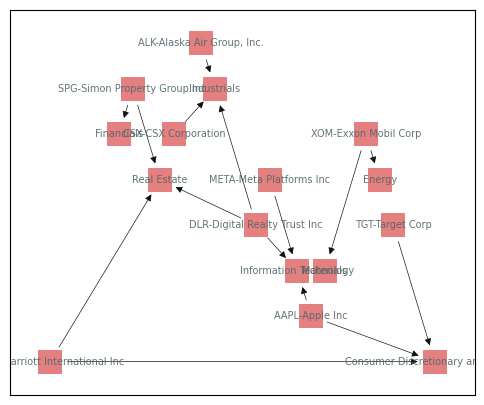

In [ ]:
plt.figure(figsize=(6,5))

# pos = nx.kamada_kawai_layout(G)
pos = nx.planar_layout(G)
# pos = nx.random_layout(G)
# pos = nx.shell_layout(G)
nx.draw_networkx(G, with_labels=True,
                 node_color='#E27271',
                 edge_cmap=plt.cm.Blues,
                 font_color="#50646A",
                 pos=pos,
                 node_shape="s",
                 alpha=0.9,
                 font_size=7,
                 linewidths=0,
                 width=0.5)
plt.show()

In [ ]:
# Extract Centrality, Betweenness, Closeness and Degree Centrality
degree_dict = nx.degree_centrality(G)
betweenness_dict = nx.betweenness_centrality(G)
closeness_dict = nx.closeness_centrality(G)
node_degree = dict(G.degree)

In [ ]:
# Communities
cluster = ['Communication Services',
           'Consumer Discretionary and Staples',
           'Energy',
           'Financials',
           'Health Care',
           'Industrials',
           'Information Technology',
           'Materials',
           'Real Estate',
           'Utilities']
communities = {k:v for k,v in node_degree.items() if k in cluster}
communities

{'Consumer Discretionary and Staples': 3,
 'Real Estate': 3,
 'Energy': 1,
 'Materials': 1,
 'Financials': 1,
 'Industrials': 3,
 'Information Technology': 3}

In [ ]:
from pyvis.network import Network

net = Network(notebook=True, height='1200px', width='100%',bgcolor="white", font_color="grey",cdn_resources='remote', select_menu=True)
#net.node_font_size = 50
nx.set_node_attributes(G, node_degree, 'size')
#nx.set_node_attributes(G, degree_dict, 'degree_centrality')
#nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
#nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
nx.set_node_attributes(G, communities, 'group')

# for n in G.nodes:
#     net.add_node(n)
# for e1, e2, attrs in G.edges.data():
#     net.add_edge(e1, e2, color=attrs['color'])

net.from_nx(G)
net.show('approach_1_demo.html')

from IPython.display import display, HTML
display(HTML("approach_1_demo.html"))


approach_1_demo.html
